In [ ]:
# Basic required modules for this project
# Lets load in to our project...
import os  #os module to interact with the system
import time # to capture the snapshots of models

import numpy as np # for max-max matrices multiplication
import pandas as pd # to handle the raw-data
import matplotlib.pyplot as plt # for analyze the data

In [ ]:
# load the pytorch modules to perform tensor operations
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader

In [ ]:
# load load navbar and scikit module for helper modules
from tqdm import tqdm_notebook
from sklearn.preprocessing import MinMaxScaler

In [ ]:
os.listdir('./')

['.config',
 'pjm_hourly_est.csv',
 'EKPC_hourly.csv',
 'PJMW_hourly.csv',
 'PJME_hourly.csv',
 'est_hourly.paruqet',
 'DUQ_hourly.csv',
 'FE_hourly.csv',
 'PJM_Load_hourly.csv',
 'DOM_hourly.csv',
 'COMED_hourly.csv',
 'DAYTON_hourly.csv',
 'NI_hourly.csv',
 'AEP_hourly.csv',
 'DEOK_hourly.csv',
 'sample_data']

In [ ]:
data_items = []
[data_items.append(item) for item in os.listdir('./') if item.endswith('.csv') or item.endswith('.paruqet')];

In [ ]:
len(data_items)

14

In [ ]:
AEP_df = pd.read_csv('./AEP_hourly.csv')
AEP_df.head()

,Datetime,AEP_MW
0,2004-12-31 01:00:00,13478.0
1,2004-12-31 02:00:00,12865.0
2,2004-12-31 03:00:00,12577.0
3,2004-12-31 04:00:00,12517.0
4,2004-12-31 05:00:00,12670.0


In [ ]:
# The scaler objects will be stored in this dictionary so that our output test data from the model can be re-scaled during evaluation
label_scalers = {}
train_x = []
test_x = {}
test_y = {}

In [ ]:
data_dir = './'
os.listdir(data_dir)

['.config',
 'pjm_hourly_est.csv',
 'EKPC_hourly.csv',
 'PJMW_hourly.csv',
 'PJME_hourly.csv',
 'est_hourly.paruqet',
 'DUQ_hourly.csv',
 'FE_hourly.csv',
 'PJM_Load_hourly.csv',
 'DOM_hourly.csv',
 'COMED_hourly.csv',
 'DAYTON_hourly.csv',
 'NI_hourly.csv',
 'AEP_hourly.csv',
 'DEOK_hourly.csv',
 'sample_data']

In [ ]:
for file in tqdm_notebook(os.listdir(data_dir)):
    # Skipping the files we're not using
    if file[-4:] != ".csv" or file == "pjm_hourly_est.csv":
        continue

    # Store csv file in a Pandas DataFrame
    df = pd.read_csv(data_dir + file, parse_dates=[0])
    # Processing the time data into suitable input formats
    df['hour'] = df.apply(lambda x: x['Datetime'].hour,axis=1)
    df['dayofweek'] = df.apply(lambda x: x['Datetime'].dayofweek,axis=1)
    df['month'] = df.apply(lambda x: x['Datetime'].month,axis=1)
    df['dayofyear'] = df.apply(lambda x: x['Datetime'].dayofyear,axis=1)
    df = df.sort_values("Datetime").drop("Datetime",axis=1)

    # Scaling the input data
    sc = MinMaxScaler()
    label_sc = MinMaxScaler()
    data = sc.fit_transform(df.values)
    # Obtaining the Scale for the labels(usage data) so that output can be re-scaled to actual value during evaluation
    label_sc.fit(df.iloc[:,0].values.reshape(-1,1))
    label_scalers[file] = label_sc

    # Define lookback period and split inputs/labels
    lookback = 90
    inputs = np.zeros((len(data)-lookback,lookback,df.shape[1]))
    labels = np.zeros(len(data)-lookback)

    for i in range(lookback, len(data)):
        inputs[i-lookback] = data[i-lookback:i]
        labels[i-lookback] = data[i,0]
    inputs = inputs.reshape(-1,lookback,df.shape[1])
    labels = labels.reshape(-1,1)

    # Split data into train/test portions and combining all data from different files into a single array
    test_portion = int(0.1*len(inputs))
    if len(train_x) == 0:
        train_x = inputs[:-test_portion]
        train_y = labels[:-test_portion]
    else:
        train_x = np.concatenate((train_x,inputs[:-test_portion]))
        train_y = np.concatenate((train_y,labels[:-test_portion]))
    test_x[file] = (inputs[-test_portion:])
    test_y[file] = (labels[-test_portion:])

<ipython-input-23-efbc334e128f>:1: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for file in tqdm_notebook(os.listdir(data_dir)):


  0%|          | 0/16 [00:00<?, ?it/s]

In [ ]:
train_x.shape, train_y.shape,

((980185, 90, 5), (980185, 1))

In [ ]:
len(test_x), len(test_y)

(12, 12)

In [ ]:
batch_size = 1024

train_data = TensorDataset(torch.from_numpy(train_x), torch.from_numpy(train_y))
train_loader = DataLoader(train_data, shuffle=True, batch_size=batch_size, drop_last=True)

In [ ]:
train_loader.dataset.tensors[0].shape, train_loader.dataset.tensors[1].shape

(torch.Size([980185, 90, 5]), torch.Size([980185, 1]))

In [ ]:
# torch.cuda.is_available() checks and returns a Boolean True if a GPU is available, else it'll return False
is_cuda = torch.cuda.is_available()

# If we have a GPU available, we'll set our device to GPU. We'll use this device variable later in our code.
if is_cuda:
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

In [ ]:
device

device(type='cuda')

In [ ]:
class GRUNet(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, n_layers, drop_prob=0.2):
        super(GRUNet, self).__init__()
        self.hidden_dim = hidden_dim
        self.n_layers = n_layers

        self.gru = nn.GRU(input_dim, hidden_dim, n_layers, batch_first=True, dropout=drop_prob)
        self.fc = nn.Linear(hidden_dim, output_dim)
        self.relu = nn.ReLU()

    def forward(self, x, h):
        out, h = self.gru(x, h)
        out = self.fc(self.relu(out[:,-1]))
        return out, h

    def init_hidden(self, batch_size):
        weight = next(self.parameters()).data
        hidden = weight.new(self.n_layers, batch_size, self.hidden_dim).zero_().to(device)
        return hidden

class LSTMNet(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, n_layers, drop_prob=0.2):
        super(LSTMNet, self).__init__()
        self.hidden_dim = hidden_dim
        self.n_layers = n_layers

        self.lstm = nn.LSTM(input_dim, hidden_dim, n_layers, batch_first=True, dropout=drop_prob)
        self.fc = nn.Linear(hidden_dim, output_dim)
        self.relu = nn.ReLU()

    def forward(self, x, h):
        out, h = self.lstm(x, h)
        out = self.fc(self.relu(out[:,-1]))
        return out, h

    def init_hidden(self, batch_size):
        weight = next(self.parameters()).data
        hidden = (weight.new(self.n_layers, batch_size, self.hidden_dim).zero_().to(device),
                  weight.new(self.n_layers, batch_size, self.hidden_dim).zero_().to(device))
        return hidden

In [ ]:
def train(train_loader, learn_rate, hidden_dim=256, EPOCHS=5, model_type="GRU"):

    # Setting common hyperparameters
    input_dim = next(iter(train_loader))[0].shape[2]
    output_dim = 1
    n_layers = 2
    # Instantiating the models
    if model_type == "GRU":
        model = GRUNet(input_dim, hidden_dim, output_dim, n_layers)
    else:
        model = LSTMNet(input_dim, hidden_dim, output_dim, n_layers)
    model.to(device)

    # Defining loss function and optimizer
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learn_rate)

    model.train()
    print("Starting Training of {} model".format(model_type))
    epoch_times = []
    # Start training loop
    for epoch in range(1,EPOCHS+1):
        start_time = time.perf_counter()
        h = model.init_hidden(batch_size)
        avg_loss = 0.
        counter = 0
        for x, label in train_loader:
            counter += 1
            if model_type == "GRU":
                h = h.data
            else:
                h = tuple([e.data for e in h])
            model.zero_grad()

            out, h = model(x.to(device).float(), h)
            loss = criterion(out, label.to(device).float())
            loss.backward()
            optimizer.step()
            avg_loss += loss.item()
            if counter%200 == 0:
                print("Epoch {}......Step: {}/{}....... Average Loss for Epoch: {}".format(epoch, counter, len(train_loader), avg_loss/counter))
        current_time = time.perf_counter()
        print("Epoch {}/{} Done, Total Loss: {}".format(epoch, EPOCHS, avg_loss/len(train_loader)))
        print("Time Elapsed for Epoch: {} seconds".format(str(current_time-start_time)))
        epoch_times.append(current_time-start_time)
    print("Total Training Time: {} seconds".format(str(sum(epoch_times))))
    return model

In [ ]:
def evaluate(model, test_x, test_y, label_scalers):
    model.eval()
    outputs = []
    targets = []
    start_time = time.perf_counter()
    for i in test_x.keys():
        inp = torch.from_numpy(np.array(test_x[i]))
        labs = torch.from_numpy(np.array(test_y[i]))
        h = model.init_hidden(inp.shape[0])
        out, h = model(inp.to(device).float(), h)
        outputs.append(label_scalers[i].inverse_transform(out.cpu().detach().numpy()).reshape(-1))
        targets.append(label_scalers[i].inverse_transform(labs.numpy()).reshape(-1))
    print("Evaluation Time: {}".format(str(time.perf_counter()-start_time)))
    sMAPE = 0
    for i in range(len(outputs)):
        sMAPE += np.mean(abs(outputs[i]-targets[i])/(targets[i]+outputs[i])/2)/len(outputs)
    print("sMAPE: {}%".format(sMAPE*100))
    return outputs, targets, sMAPE

In [ ]:
lr = 0.001
gru_model = train(train_loader, lr, model_type="GRU")

Starting Training of GRU model
Epoch 1......Step: 200/957....... Average Loss for Epoch: 0.007325095309643075
Epoch 1......Step: 400/957....... Average Loss for Epoch: 0.004076449577405583
Epoch 1......Step: 600/957....... Average Loss for Epoch: 0.0028789552582990535
Epoch 1......Step: 800/957....... Average Loss for Epoch: 0.0022463993722340093
Epoch 1/5 Done, Total Loss: 0.0019263796383746615
Time Elapsed for Epoch: 132.51985662399966 seconds
Epoch 2......Step: 200/957....... Average Loss for Epoch: 0.0002688536114874296
Epoch 2......Step: 400/957....... Average Loss for Epoch: 0.0002509072635075427
Epoch 2......Step: 600/957....... Average Loss for Epoch: 0.00023711903057119344
Epoch 2......Step: 800/957....... Average Loss for Epoch: 0.0002302675635110063
Epoch 2/5 Done, Total Loss: 0.0002220303982290923
Time Elapsed for Epoch: 138.6652698480002 seconds
Epoch 3......Step: 200/957....... Average Loss for Epoch: 0.0001852821664942894
Epoch 3......Step: 400/957....... Average Loss fo

In [ ]:
lstm_model = train(train_loader, lr, model_type="LSTM")

Starting Training of LSTM model
Epoch 1......Step: 200/957....... Average Loss for Epoch: 0.008789566210471094
Epoch 1......Step: 400/957....... Average Loss for Epoch: 0.004944736389588798
Epoch 1......Step: 600/957....... Average Loss for Epoch: 0.0035056977363031668
Epoch 1......Step: 800/957....... Average Loss for Epoch: 0.0027352975031681125
Epoch 1/5 Done, Total Loss: 0.002340155123096045
Time Elapsed for Epoch: 189.789518263 seconds
Epoch 2......Step: 200/957....... Average Loss for Epoch: 0.0002702794796641683
Epoch 2......Step: 400/957....... Average Loss for Epoch: 0.0002530375272544916
Epoch 2......Step: 600/957....... Average Loss for Epoch: 0.0002395426790462807
Epoch 2......Step: 800/957....... Average Loss for Epoch: 0.0002267216594555066
Epoch 2/5 Done, Total Loss: 0.00022092828946589525
Time Elapsed for Epoch: 188.97317068099983 seconds
Epoch 3......Step: 200/957....... Average Loss for Epoch: 0.00016821975266793744
Epoch 3......Step: 400/957....... Average Loss for E

In [ ]:
gru_outputs, targets, gru_sMAPE = evaluate(gru_model, test_x, test_y, label_scalers)

Evaluation Time: 4.0679702269999325
sMAPE: 0.2714377392196534%


In [ ]:
lstm_outputs, targets, lstm_sMAPE = evaluate(lstm_model, test_x, test_y, label_scalers)

Evaluation Time: 5.556171492999965
sMAPE: 0.26289418291395844%


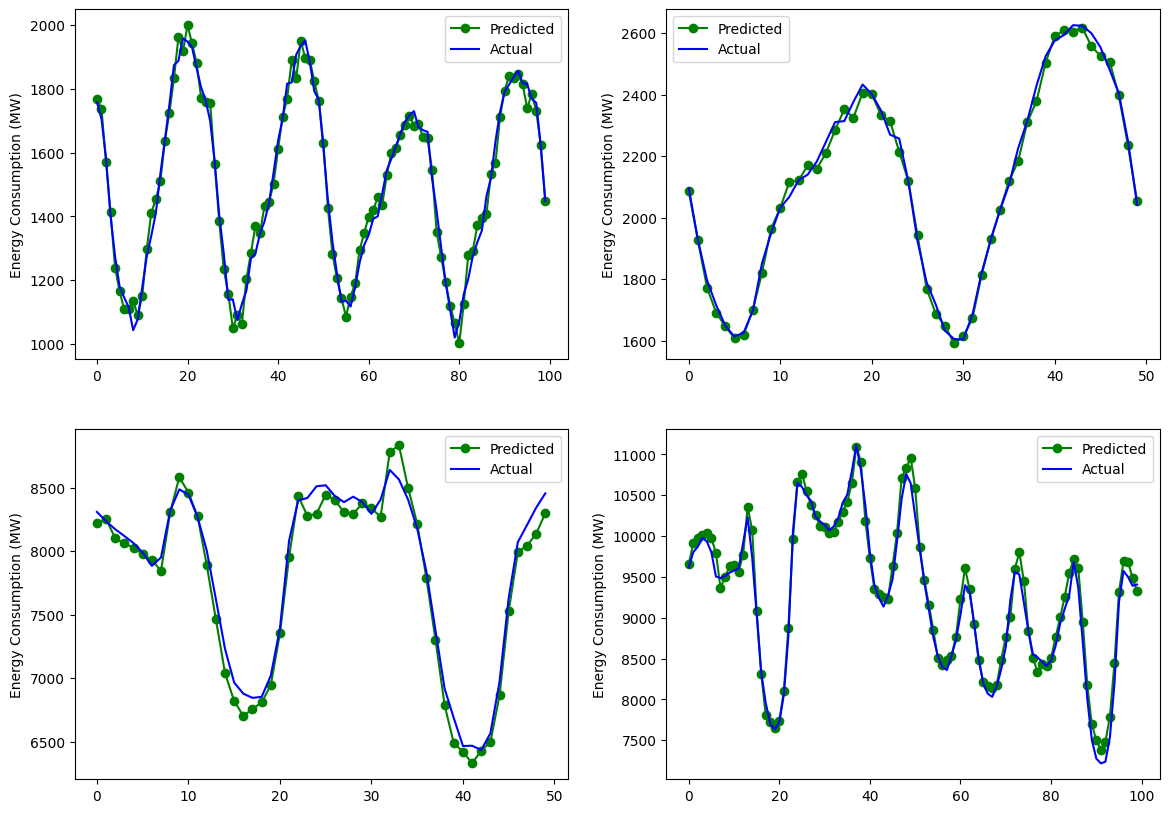

In [ ]:
plt.figure(figsize=(14,10))
plt.subplot(2,2,1)
plt.plot(gru_outputs[0][-100:], "-o", color="g", label="Predicted")
plt.plot(targets[0][-100:], color="b", label="Actual")
plt.ylabel('Energy Consumption (MW)')
plt.legend()

plt.subplot(2,2,2)
plt.plot(gru_outputs[8][-50:], "-o", color="g", label="Predicted")
plt.plot(targets[8][-50:], color="b", label="Actual")
plt.ylabel('Energy Consumption (MW)')
plt.legend()

plt.subplot(2,2,3)
plt.plot(gru_outputs[4][:50], "-o", color="g", label="Predicted")
plt.plot(targets[4][:50], color="b", label="Actual")
plt.ylabel('Energy Consumption (MW)')
plt.legend()

plt.subplot(2,2,4)
plt.plot(lstm_outputs[6][:100], "-o", color="g", label="Predicted")
plt.plot(targets[6][:100], color="b", label="Actual")
plt.ylabel('Energy Consumption (MW)')
plt.legend()
plt.show()